<a href="https://colab.research.google.com/github/mayarachew/IronyDetectionInTweets/blob/main/irony_detection_experiment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [2]:
# Dataset
from sklearn.datasets import fetch_20newsgroups

from pprint import pprint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Vectorizing and spliting
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# Classifications
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

# Preprocessing
import re, string
import nltk
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords 
from nltk.tokenize import TweetTokenizer
nltk.download('punkt')
from sklearn.preprocessing import MinMaxScaler

import time
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

# Classification
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Test hyperparameters
from sklearn.model_selection import RandomizedSearchCV

# Confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Read files

In [3]:
def read_files(file_path):
  print()
  print(file_path)

  # Read tweets
  df = pd.read_csv(file_path, encoding='utf8', sep='\t')
  
  # Remove 'Tweet index' column
  df = df.iloc[: , 1:]

  # Drop rows with nan values
  df = df.dropna()

  # Print (rows, columns) without nan values
  print('Shape:', df.shape)

  # Print head of data
  print(df.head())

  # Find labels (columns)
  labels = df['Label'].unique()

  # Print labels
  print('Labels:', labels) 

  return df

In [8]:
tweets_train_df = read_files('ironico-train.txt')
tweets_test_df = read_files('ironico-test.txt')


ironico-train.txt
Shape: (9868, 2)
                                                text        Label
0  Jogo será em Manaus, muito mais longe que a Co...      ironico
1  Diferença de renda entre brancos enegros cresc...  nao-ironico
2  ECONOMIA CRISE RECESSÃO FORATEMER DIRETASJÁ: C...  nao-ironico
3  Instagram, aquele programa de tirar foto da co...      ironico
4  • MARQUEM OS AMIGOS •bomdia boatarde boanoite ...      ironico
Labels: ['ironico' 'nao-ironico']

ironico-test.txt
Shape: (2310, 2)
                                                text        Label
0  Reforma trabalhista elevará produtividade, diz...  nao-ironico
1  humornegro  Aconteceu comigo, dentro da minha ...      ironico
2  Acho impressionante a capacidade do ser humano...      ironico
3  Rodrigo Caetano incompetente, vascaíno, trouxe...      ironico
4                   tens razão ela é super feia ..        ironico
Labels: ['nao-ironico' 'ironico']


# Preprocessing

In [9]:
def preprocessing(tweets):
  # Define Labels
  tweets['Label'] = tweets['Label'].replace(['ironico', 'nao-ironico'], [1,0])
  tweets.rename(columns = {'text': 'Tweet text'}, inplace=True)

  # Remove links
  tweets['Tweet text'] = tweets['Tweet text'].str.replace(
      "\S*https?:\S*", "", regex=True
  )

  # Remove mentions
  tweets['Tweet text'] = tweets['Tweet text'].str.replace(
      "@[^ ]*", "", regex=True
  )

  # Convert to lower case
  tweets['Tweet text'] = tweets['Tweet text'].str.lower()

  # Remove spaces x2
  tweets['Tweet text'] = tweets['Tweet text'].str.replace(
      "[ ]{2,}", "", regex=True
  )

  print(tweets.head())

  return tweets

In [10]:
print('\ntweets_train_df_pp')
tweets_train_df_pp = preprocessing(tweets_train_df)
print('\ntweets_test_df_pp')
tweets_test_df_pp = preprocessing(tweets_test_df)


tweets_train_df_pp
                                          Tweet text  Label
0  jogo será em manaus, muito mais longe que a co...      1
1  diferença de renda entre brancos enegros cresc...      0
2  economia crise recessão foratemer diretasjá: c...      0
3  instagram, aquele programa de tirar foto da co...      1
4  • marquem os amigos •bomdia boatarde boanoitef...      1

tweets_test_df_pp
                                          Tweet text  Label
0  reforma trabalhista elevará produtividade, diz...      0
1  humornegroaconteceu comigo, dentro da minha fa...      1
2  acho impressionante a capacidade do ser humano...      1
3  rodrigo caetano incompetente, vascaíno, trouxe...      1
4                     tens razão ela é super feia ..      1


# TF-IDF

In [11]:
def apply_tfidf(X):
  # Convert data into a matrix of TF-IDF features
  vectorizer = TfidfVectorizer(norm="l1")
  features = vectorizer.fit_transform(X)
  X_tfidf = pd.DataFrame(features.todense(), columns=vectorizer.get_feature_names())
  
  return X_tfidf

In [12]:
X_tfidf_train_h = apply_tfidf(tweets_train_df_pp['Tweet text'])
X_tfidf_test_h = apply_tfidf(tweets_test_df_pp['Tweet text'])

print(X_tfidf_train_h.shape, X_tfidf_test_h.shape)

(9868, 20671) (2310, 7855)


In [13]:
X = tweets_train_df_pp['Tweet text'].append(tweets_test_df_pp['Tweet text'])
X_tfidf = apply_tfidf(X)

X_tfidf.shape

(12178, 23690)

In [14]:
# Get len
rows_tweets_train = len(tweets_train_df_pp['Tweet text'])

rows_tweets_test = len(tweets_test_df_pp['Tweet text'])

# Divide tfidf
X_tfidf_train = X_tfidf[:rows_tweets_train]
X_tfidf.drop(X_tfidf.index[:rows_tweets_train])

X_tfidf_test = X_tfidf[:rows_tweets_test]
X_tfidf.drop(X_tfidf.index[:rows_tweets_test])

,00,000,001,00hs,00politicaspublicas,01,012,02,03,04,047,05,06,07,08,08fiquei,09,0ibxxrocnc,10,100,1000,10000,100000,100fanti,100happydaysheart,101,107,1075,109,10h,10m,10mil,10min,10on,10ª,11,110,111,112,118,...,ñpode,óbvia,óbviasirônia,óbvio,óculos,ódio,óhahahaha,óia,óleo,ópera,óptima,órfã,órgão,óscar,ótima,ótimaparabéns,ótimas,ótimo,ótimos,ótimosábado,óvulos,óó,ôe,ômega3,ônibus,úlitmos,últim,última,últimamente,últimas,último,últimoesfuerzo,últimos,única,únicas,único,útero,útil,ṕraia,방탄소년단
2310,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2311,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2312,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2313,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2314,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12173,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12174,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12175,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12176,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
print(X_tfidf_train.shape,
      X_tfidf_test.shape)

(9868, 23690) (2310, 23690)


# Word2Vec

In [23]:
def apply_word2vec(X):
  # Tokenize
  X = [TweetTokenizer().tokenize(text) for text in X]

  # Define Word2Vec
  vectorizer = Word2Vec(X, window=5, min_count=1, workers=4)
  X_word2vec = []

  # Sum embeddings
  for text in X:
    vectorizer.train(text, total_examples=1, epochs=1)
    words = [vectorizer.wv[word] for word in text]
    embeddings = np.sum(words, axis=0)
    X_word2vec.append(embeddings)

  return X_word2vec

In [24]:
X_word2vec_train = apply_word2vec(tweets_train_df_pp['Tweet text'])
X_word2vec_test = apply_word2vec(tweets_test_df_pp['Tweet text'])

In [25]:
X_word2vec_train[0]

array([ -6.5982485 ,  -2.5607972 , -12.566344  ,  -6.567514  ,
         0.27118278, -10.178909  ,   2.7426372 ,  -1.9999963 ,
         7.1199703 ,   8.288435  , -12.910002  ,  -3.219226  ,
         5.952793  ,  -7.0894666 ,  -0.5355723 ,  -7.528922  ,
         8.933626  ,   4.7216883 ,  -0.32701597,   0.3083505 ,
         2.8497603 ,  -0.17206517, -10.113854  ,   3.2153356 ,
         3.5779781 ,  -6.376062  , -11.759377  ,  -9.749552  ,
        -6.837224  ,  -1.3443983 ,  -4.2490325 ,  11.975881  ,
         3.2107534 ,  -3.1035736 ,   3.5913894 ,  -2.5562177 ,
        14.11853   ,   1.1018894 ,   5.3348465 ,  -0.2881456 ,
        -7.3811274 ,   7.1101236 ,  -4.7145214 ,   1.2495685 ,
         7.992506  , -10.541563  ,  -0.83102214,   6.8195972 ,
        -0.17705984,  -3.2717621 ,  -8.021229  ,   8.101253  ,
        -3.5094829 ,   0.05383798,   2.3388014 ,  11.021433  ,
         2.7063138 ,  -2.3306248 ,  -2.1082354 ,   9.284414  ,
       -10.0649605 ,  -4.4043427 ,  -7.6678214 , -10.61

In [26]:
# Normalize data for word2vec Naive Bayes
scaler = MinMaxScaler()

X_word2vec_train_normalized = scaler.fit(X_word2vec_train).transform(X_word2vec_train)
X_word2vec_test_normalized = scaler.fit(X_word2vec_test).transform(X_word2vec_test)

# Test hyperparameters

In [11]:
def test_hyperparameters(classifier, X_train, y_train):
    parameters = {}
    classification = None

    if classifier == 'Random Forest':
        parameters = {'n_estimators': [100, 300, 500], "max_depth": [
            3, 5, 7, None], 'criterion': ['gini', 'entropy'], 'max_features': ['auto', 'sqrt', 'log2']}
        classification = RandomForestClassifier(random_state=0)
    elif classifier == 'Naive Bayes':
        parameters = {'alpha': [1, 0.1, 0.01, 0.001, 0.0001]}
        classification = MultinomialNB()
    elif classifier == 'SVM':
        parameters = {'kernel': ['rbf', 'poly', 'sigmoid', 'linear'], "C": [1, 10, 100, 1000]}
        classification = SVC(random_state=0)

    score = 'f1'

    print("# Defining hyperparameters based on %s" % score)
    print()

    clf = RandomizedSearchCV(classification, parameters, scoring="%s_macro" % score, cv=5)
    clf.fit(X_train, y_train)

    print("Best hyperparameters:")
    print()
    print(clf.best_params_)

Test tfidf hyperparameters

In [ ]:
test_hyperparameters('Naive Bayes', X_tfidf_train_h, tweets_train_df['Label'])

# Defining hyperparameters based on f1

Best hyperparameters:

{'alpha': 0.0001}


In [12]:
test_hyperparameters('SVM', X_tfidf_test_h, tweets_test_df['Label'])

# Defining hyperparameters based on f1

Best hyperparameters:

{'kernel': 'linear', 'C': 1000}


In [13]:
test_hyperparameters('Random Forest', X_tfidf_test_h, tweets_test_df['Label'])

# Defining hyperparameters based on f1

Best hyperparameters:

{'n_estimators': 100, 'max_features': 'auto', 'max_depth': None, 'criterion': 'gini'}


Test word2vec hyperparameters

In [18]:
test_hyperparameters('Naive Bayes', X_word2vec_train_normalized, tweets_train_df['Label'])

# Defining hyperparameters based on f1

Best hyperparameters:

{'alpha': 0.1}


In [20]:
test_hyperparameters('SVM', X_word2vec_train, tweets_train_df['Label'])

# Defining hyperparameters based on f1

Best hyperparameters:

{'kernel': 'linear', 'C': 100}


In [19]:
test_hyperparameters('Random Forest', X_word2vec_train, tweets_train_df['Label'])

# Defining hyperparameters based on f1

Best hyperparameters:

{'n_estimators': 100, 'max_features': 'auto', 'max_depth': None, 'criterion': 'entropy'}


# Classification

In [16]:
def createClassifier(classifier, x_train, y_train, x_test, y_test):
    # Create classifier
    classifier.fit(x_train, y_train)

    # Define test labels
    y_true, y_pred = y_test, classifier.predict(x_test)

    print('Classification report: ')
    print(classification_report(y_true, y_pred, zero_division=1))
    
    return y_pred

In [17]:
def plotConfusionMatrix(classifier, x_test, y_test):
    ConfusionMatrixDisplay.from_estimator(classifier, x_test, y_test, cmap=plt.cm.Blues)
    plt.show()

    return;

In [18]:
y_tweets_train_df = tweets_train_df['Label']

y_test = tweets_test_df['Label']

Classification report: 
              precision    recall  f1-score   support

           0       0.21      0.20      0.21       408
           1       0.83      0.84      0.83      1902

    accuracy                           0.73      2310
   macro avg       0.52      0.52      0.52      2310
weighted avg       0.72      0.73      0.72      2310

Confusion Matrix: 


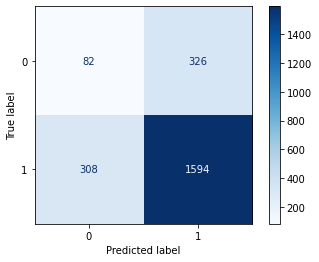

In [22]:
# TF-IDF and Naive Bayes
nb_clf = MultinomialNB(alpha=0.0001)

y_pred = createClassifier(nb_clf, X_tfidf_train, y_tweets_train_df, 
                          X_tfidf_test, y_test)

print('Confusion Matrix: ')
plotConfusionMatrix(nb_clf, X_tfidf_test, y_test)

Classification report: 
              precision    recall  f1-score   support

           0       0.21      0.21      0.21       408
           1       0.83      0.83      0.83      1902

    accuracy                           0.72      2310
   macro avg       0.52      0.52      0.52      2310
weighted avg       0.72      0.72      0.72      2310

Confusion Matrix: 


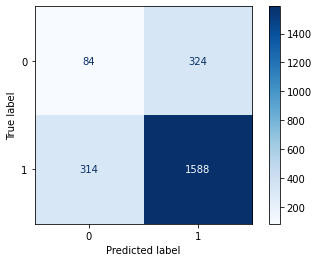

In [27]:
# TF-IDF and Support Vector Machine
svm_clf = SVC(kernel='linear', C=1000)

y_pred = createClassifier(svm_clf, X_tfidf_train, y_tweets_train_df, 
                          X_tfidf_test, y_test)

print('Confusion Matrix: ')
plotConfusionMatrix(svm_clf, X_tfidf_test, y_test)

Classification report: 
              precision    recall  f1-score   support

           0       0.21      0.21      0.21       408
           1       0.83      0.83      0.83      1902

    accuracy                           0.72      2310
   macro avg       0.52      0.52      0.52      2310
weighted avg       0.72      0.72      0.72      2310

Confusion Matrix: 


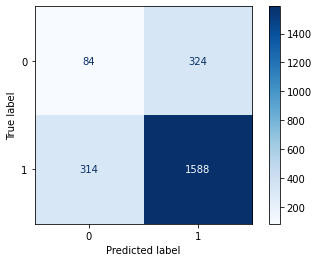

In [20]:
# TF-IDF and Random Forest
rf_clf = RandomForestClassifier(n_estimators=100, max_features='auto', max_depth=None, criterion='gini')

y_pred = createClassifier(rf_clf, X_tfidf_train, y_tweets_train_df, 
                          X_tfidf_test, y_test)

print('Confusion Matrix: ')
plotConfusionMatrix(rf_clf, X_tfidf_test, y_test)

Classification report: 
              precision    recall  f1-score   support

           0       1.00      0.00      0.00       408
           1       0.82      1.00      0.90      1902

    accuracy                           0.82      2310
   macro avg       0.91      0.50      0.45      2310
weighted avg       0.85      0.82      0.74      2310

Confusion Matrix: 


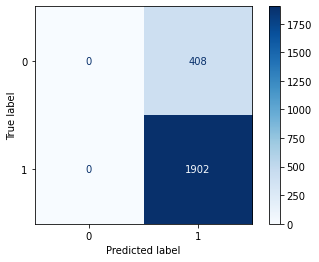

In [29]:
# Word2vec and Naive Bayes
nb_clf = MultinomialNB(alpha=0.1)

y_pred = createClassifier(nb_clf, X_word2vec_train_normalized, y_tweets_train_df, 
                          X_word2vec_test, y_test)

print('Confusion Matrix: ')
plotConfusionMatrix(nb_clf, X_word2vec_test, y_test)

Classification report: 
              precision    recall  f1-score   support

           0       0.18      1.00      0.30       408
           1       1.00      0.01      0.02      1902

    accuracy                           0.18      2310
   macro avg       0.59      0.50      0.16      2310
weighted avg       0.85      0.18      0.07      2310

Confusion Matrix: 


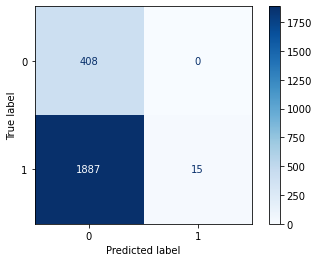

In [30]:
# Word2vec and Support Vector Machine
svm_clf = SVC(kernel='linear', C=100)

y_pred = createClassifier(svm_clf, X_word2vec_train, y_tweets_train_df, 
                          X_word2vec_test, y_test)

print('Confusion Matrix: ')
plotConfusionMatrix(svm_clf, X_word2vec_test, y_test)

Classification report: 
              precision    recall  f1-score   support

           0       0.07      0.00      0.00       408
           1       0.82      0.99      0.90      1902

    accuracy                           0.82      2310
   macro avg       0.45      0.50      0.45      2310
weighted avg       0.69      0.82      0.74      2310

Confusion Matrix: 


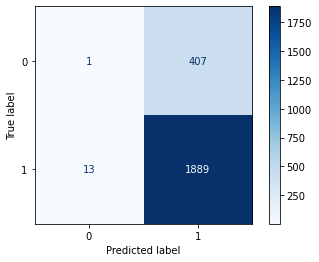

In [31]:
# Word2vec and Random Forest
rf_clf = RandomForestClassifier(n_estimators=100, max_features='auto', max_depth=None, criterion='entropy')

y_pred = createClassifier(rf_clf, X_word2vec_train, y_tweets_train_df, 
                          X_word2vec_test, y_test)

print('Confusion Matrix: ')
plotConfusionMatrix(rf_clf, X_word2vec_test, y_test)